<a href="https://colab.research.google.com/github/Fezzaioussama/Auto-encoder-/blob/main/Auto_encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Convolution Auto-encoder

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Transforms images to a PyTorch Tensor
tensor_transform = transforms.ToTensor()

# Download the MNIST Dataset
dataset = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transforms.Compose([transforms.Resize((32, 32)), tensor_transform])
)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# DataLoader for training and validation sets
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)

# Define the NN architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # encoder layers
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1=nn.Linear()
        # decoder layers
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)

    def forward(self, x):
        # encode
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # compressed representation
        # decode
        x = F.relu(self.t_conv1(x))
        x = torch.sigmoid(self.t_conv2(x))
        return x

# Initialize the NN
model = ConvAutoencoder()

# Validation using MSE Loss function
loss_function = nn.MSELoss()

# Using an Adam Optimizer with lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# Number of epochs to train the model
n_epochs = 10

train_losses = []
val_losses = []

for epoch in range(1, n_epochs + 1):
    # Monitor training loss
    train_loss = 0.0
    # Train the model
    for data in train_loader:
        images, _ = data
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)

    # Calculate average training loss
    train_loss = train_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_data in val_loader:
            val_images, _ = val_data
            val_outputs = model(val_images)
            val_loss += loss_function(val_outputs, val_images).item() * val_images.size(0)

    # Calculate average validation loss
    val_loss = val_loss / len(val_loader)
    val_losses.append(val_loss)

    # Print and visualize the losses
    print(f'Epoch: {epoch}\tTraining Loss: {train_loss:.6f}\tValidation Loss: {val_loss:.6f}')

# Plotting the loss curves
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Autoencoder Training and Validation Losses')
plt.show()

# Visualize some original and reconstructed images
model.eval()
with torch.no_grad():
    for data in val_loader:
        images, _ = data
        outputs = model(images)
        # Visualize the first batch of images
        for i in range(min(5, len(images))):
            plt.figure(figsize=(8, 4))
            plt.subplot(1, 2, 1)
            plt.imshow(images[i, 0].numpy(), cmap='gray')
            plt.title('Original Image')
            plt.subplot(1, 2, 2)
            plt.imshow(outputs[i, 0].numpy(), cmap='gray')
            plt.title('Reconstructed Image')
            plt.show()
        break  # Break after the first batch to keep the output manageable


#Linear Auto-encoder

In [6]:
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt

In [ ]:
tensor_transform=transforms.ToTensor()

dataset=datasets.MNIST(root='/root',train=True,download=True,transform=tensor_transform)
loader =torch.utils.data.DataLoader(dataset=dataset,batch_size=32,shuffle=32)


In [17]:
class Autoencoder(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder=torch.nn.Sequential(
        torch.nn.Linear(28*28,128),
        torch.nn.ReLU(),
        torch.nn.Linear(128,64),
        torch.nn.ReLU(),
        torch.nn.Linear(64,36),
        torch.nn.ReLU(),
        torch.nn.Linear(36,18),
        torch.nn.ReLU(),
        torch.nn.Linear(18,9)
    )

    self.decoder=torch.nn.Sequential(
        torch.nn.Linear(9,18),
        torch.nn.ReLU(),
        torch.nn.Linear(18,36),
        torch.nn.ReLU(),
        torch.nn.Linear(36,64),
        torch.nn.ReLU(),
        torch.nn.Linear(64,128),
        torch.nn.ReLU(),
        torch.nn.Linear(128,28*28)
    )
  def forward(self,x):
      xl=self.encoder(x)
      y=self.decoder(xl)
      return y


In [20]:
model=Autoencoder()
loss_function=torch.nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.1,weight_decay=1e-8)

In [ ]:
epochs=20
outputs=[]
losses=[]
for i in range(epochs):
  for(image,_) in loader:
    img=image.reshape(-1,28*28)
    reconstructed_image=model(img)
    loss=loss_function(reconstructed_image,img)
    losses.append(loss)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  outputs.append((epochs,image,reconstructed_image))

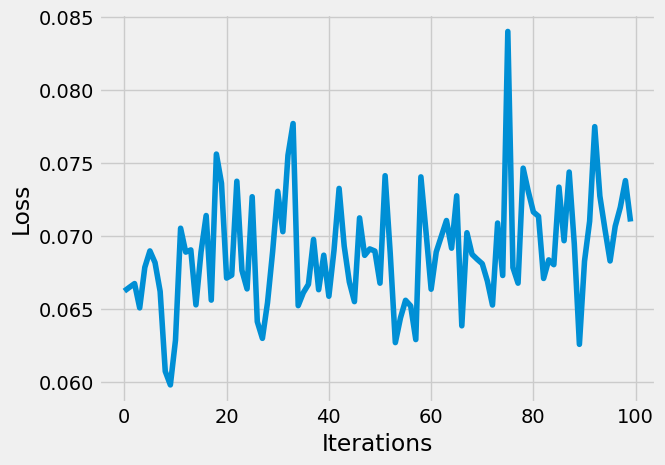

In [25]:
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')
#plt.plot(losses[-100:])
plt.plot([item.detach().numpy() for item in losses[-100:]])

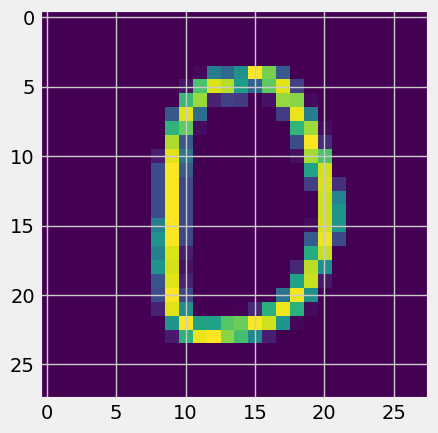

In [38]:
for i,item in enumerate(image):
    item=item.reshape(-1,28,28)
    plt.imshow(item[0])

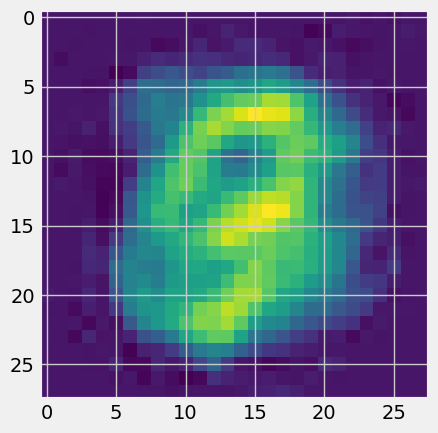

In [39]:

with torch.no_grad():
  for i,item in enumerate(reconstructed_image):
    item=item.reshape(-1,28,28)
    plt.imshow(item[0])
